# Notebook to create .h5 format dataset for Nemours OCT dataset
- Read each patient b-scan images and store them 
    - Crop the images
    - Normalize the images
    - Load them in .h5 file under 'images' key
- Read each patient b-scan annotations from .xls file 
    - Load the annotations
    - Normalize the annotations
    - Load them in .h5 file under 'layer_maps' key
- Read each b-scan image name and store them under 'name' key

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
import cv2


In [15]:
img_dir = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/data/3_R_4_1015.jpg'


## Crop the image

True

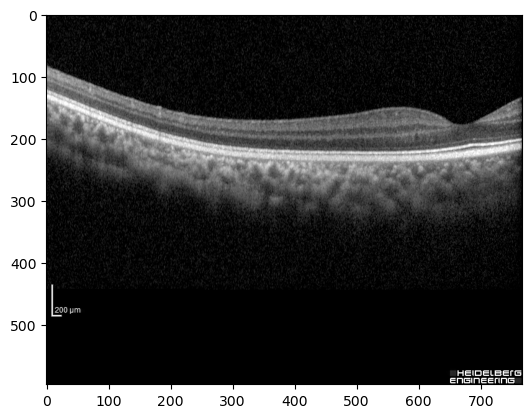

In [18]:
img = cv2.imread(img_dir)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# annotation region starts at x=0 and ends at x=767 (adjust as needed)
x_end = gray.shape[1]           # rightmost pixel
x_start = x_end - 767 
y_start = 0
y_end = gray.shape[0]  # full height for now

# Crop image
cropped_img = gray[y_start:y_end, x_start:x_end]

# Save or display
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
#plt.imshow(cropped_img)
cv2.imwrite('x_axis_cropped_1015.png', cropped_img)

In [23]:
img_dir = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/x_axis_cropped_1015.png'

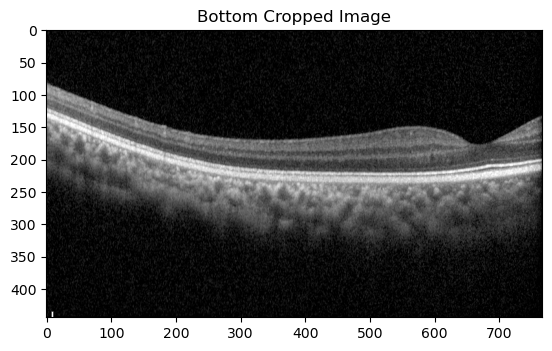

In [25]:
img = cv2.imread(img_dir)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

x_start_crop = 200
x_end_crop = 400

# Scan from bottom up to find the first row with non-black pixels in the x-range
for y in range(gray.shape[0] - 1, -1, -1):
    row_pixels = gray[y, x_start_crop:x_end_crop]
    if np.any(row_pixels > 10):  # threshold for "not black"
        bottom_crop = y + 1  # +1 to include the first non-black row
        break
else:
    bottom_crop = gray.shape[0]  # fallback: no gray found

# Crop the image from the top to bottom_crop
cropped_img = gray[0:bottom_crop, :]

cv2.imwrite('final_cropped_bscan_1015.png', cropped_img)
#plt.imshow(cropped_img)
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.title('Bottom Cropped Image')
plt.show()

## Read the Annotations

In [26]:
lyr_dir = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/data/3_R_4_1_Segm.xls'

In [30]:
import pandas as pd
data = pd.read_csv(lyr_dir, sep=None, engine='python')
print(data.head())
'''
data = pd.read_excel(lyr_dir, engine='xlrd')  # Use 'openpyxl' for .xlsx files
print(data.head())
'''

  Lastname Firstname    DOB PatientID    Eye ImageID    ExamDate  \
0      NaN       NaN    NaN      3R41      R   18421  10/15/2020   
1    ILM.1     ILM.2  ILM.3     ILM.4  ILM.5   ILM.6       ILM.7   
2      NaN       NaN    NaN       NaN    NaN     NaN         NaN   
3      NaN       NaN    NaN       NaN    NaN     NaN         NaN   
4    NFL.1     NFL.2  NFL.3     NFL.4  NFL.5   NFL.6       NFL.7   

         ExamTime AQMVersion Quality  ... Unnamed: 758 Unnamed: 759  \
0  13:07:30 (UTC)   6.13.3.0      32  ...          NaN          NaN   
1           ILM.8      ILM.9  ILM.10  ...      ILM.759      ILM.760   
2             NaN        NaN     NaN  ...       477011       476139   
3             NaN        NaN     NaN  ...          NaN          NaN   
4           NFL.8      NFL.9  NFL.10  ...      NFL.759      NFL.760   

  Unnamed: 760 Unnamed: 761 Unnamed: 762 Unnamed: 763 Unnamed: 764  \
0          NaN          NaN          NaN          NaN          NaN   
1      ILM.761      ILM.

"\ndata = pd.read_excel(lyr_dir, engine='xlrd')  # Use 'openpyxl' for .xlsx files\nprint(data.head())\n"

In [31]:
#define the layers
layers = ['ILM', 'NFL', 'GCL', 'IPL', 'INL', 'OPL', 'ELM', 'PR1', 'PR2', 'RPE', 'BM']

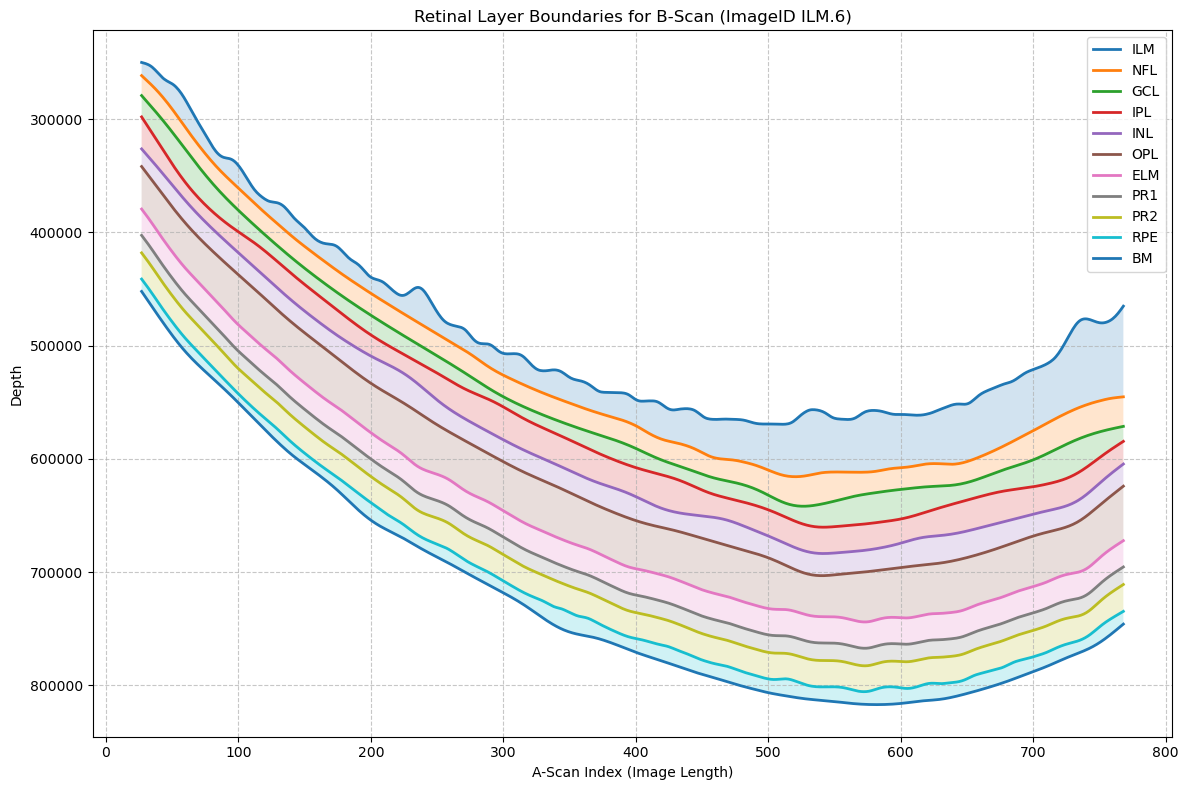

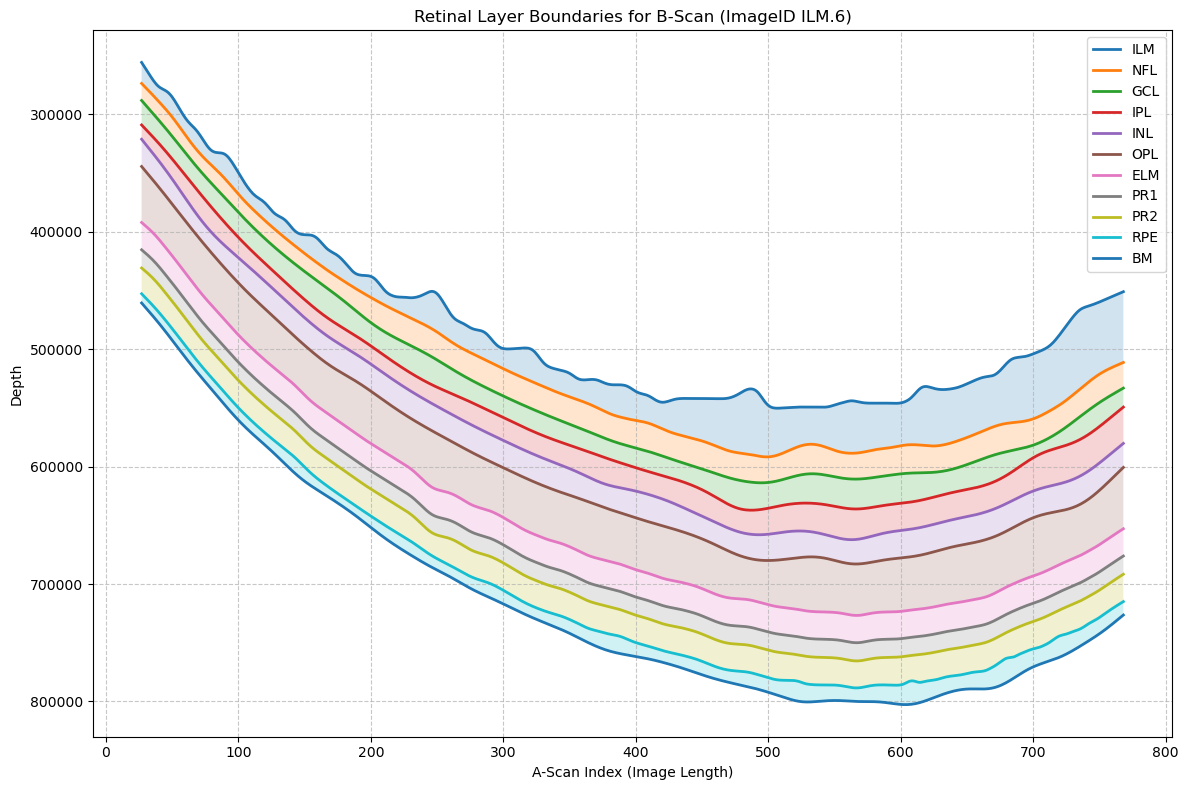

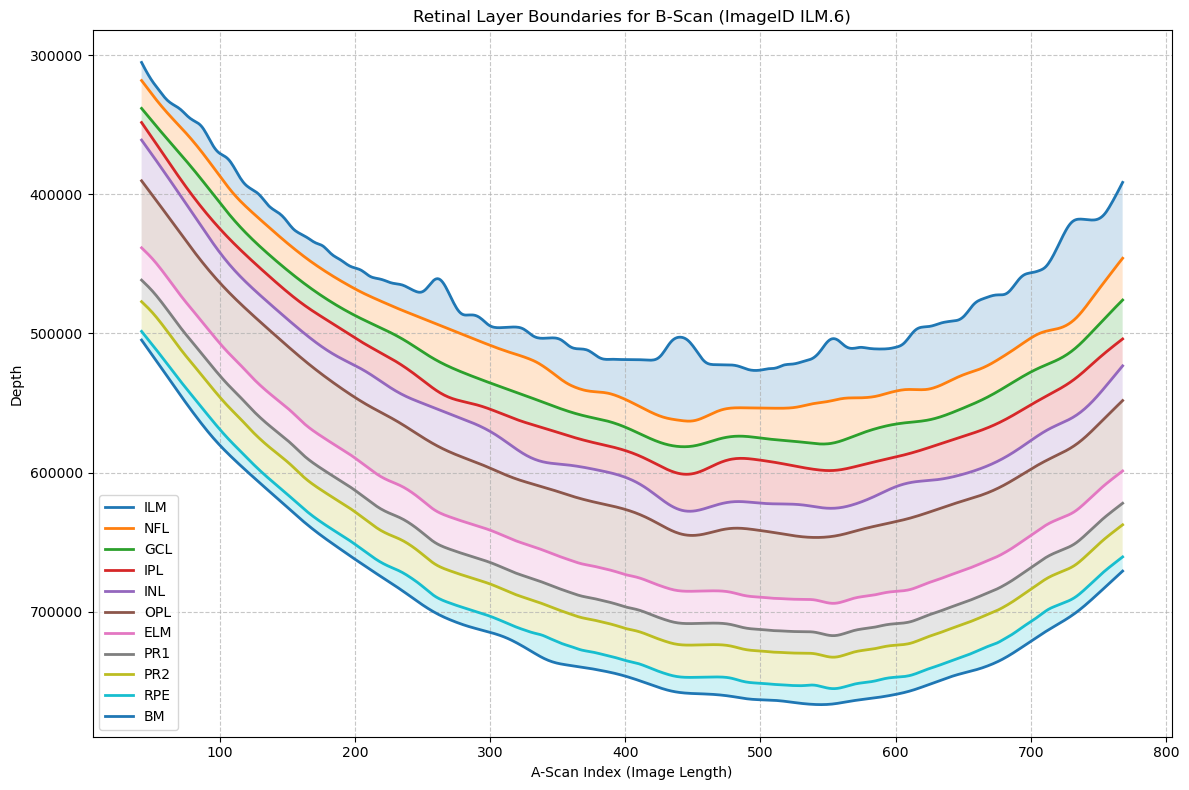

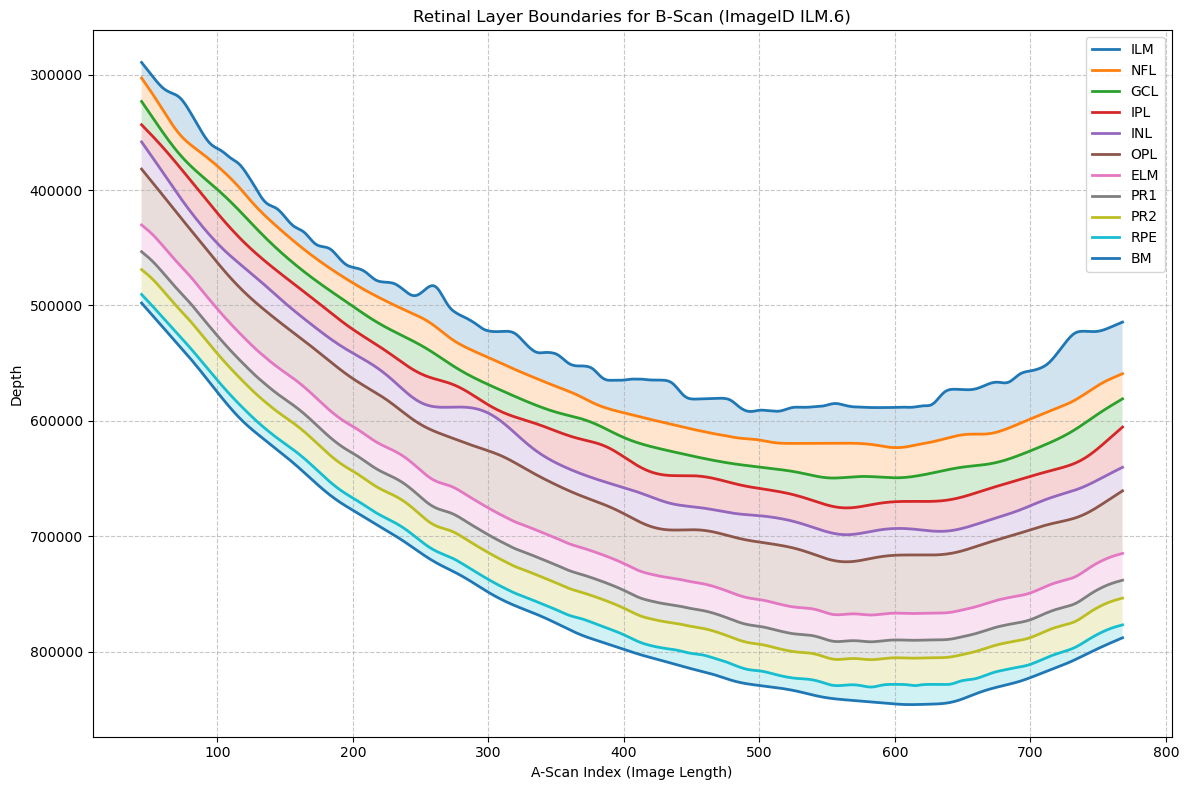

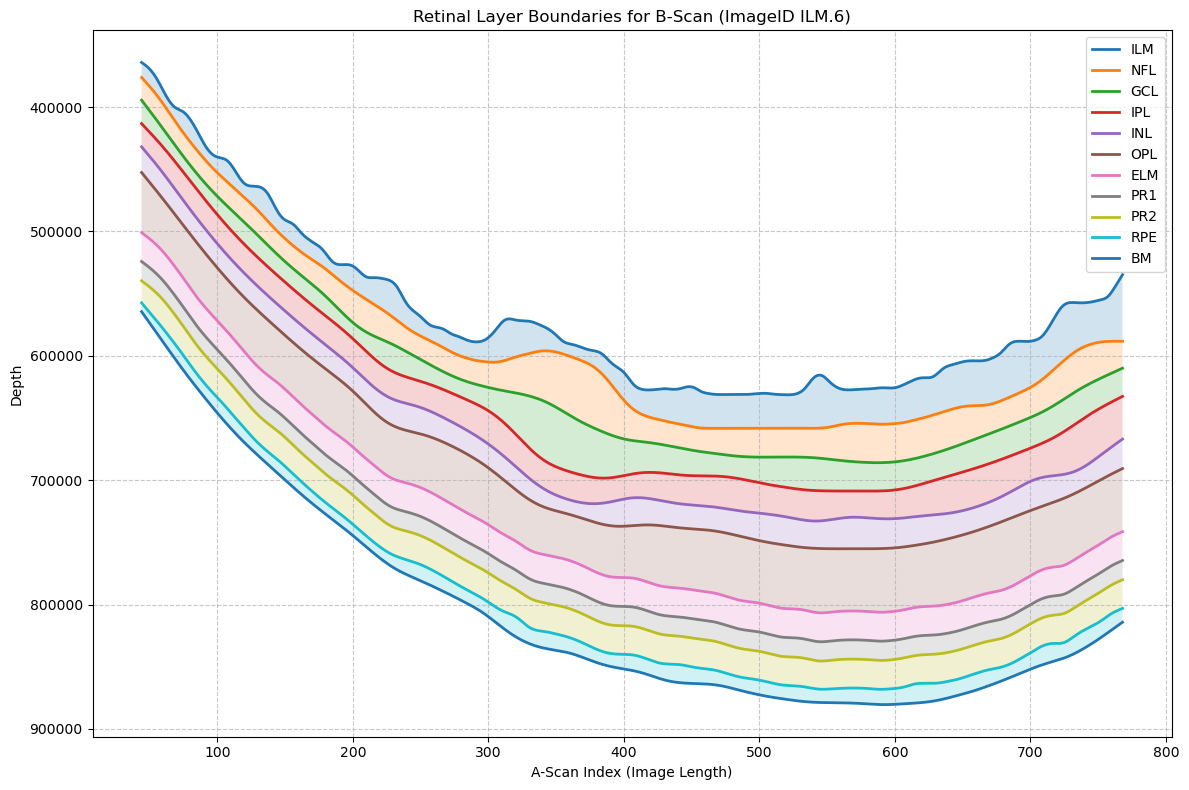

KeyboardInterrupt: 

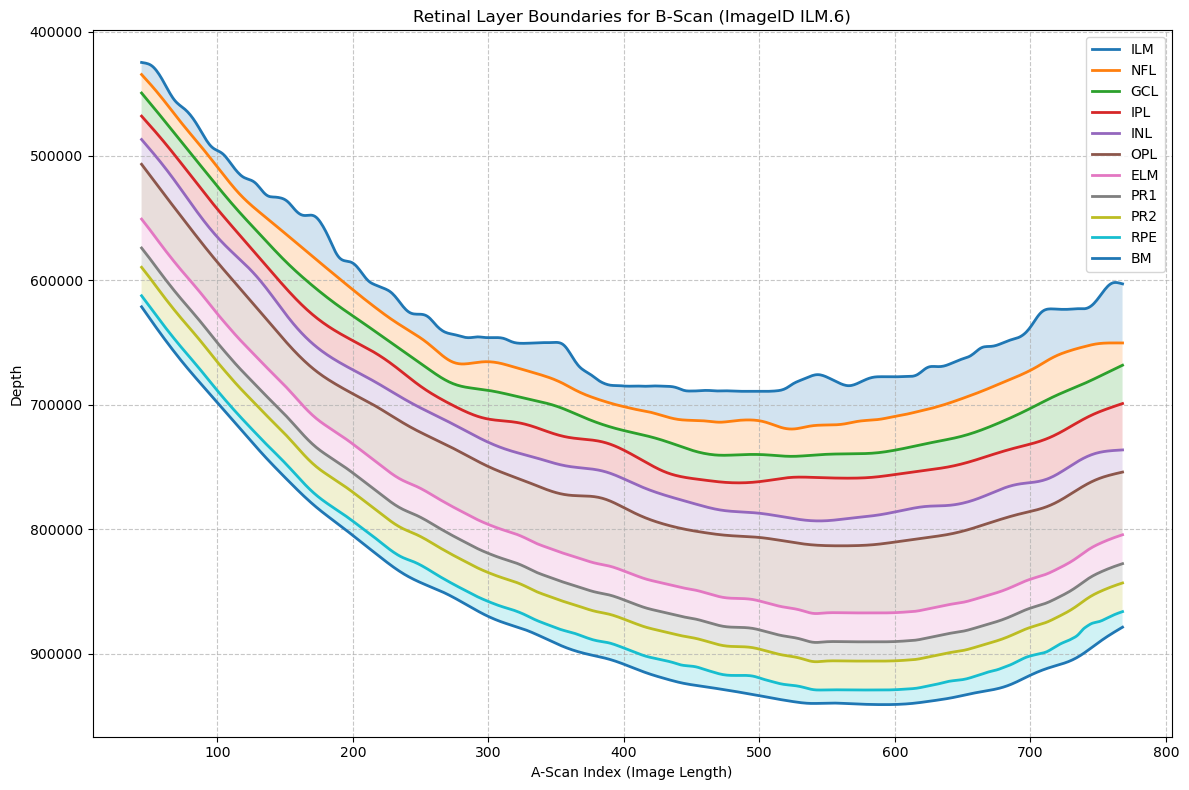

In [32]:
#loop through all the B-scans
row_idx = 1 #starting row for first ImageID
while row_idx < len(data):
    #get the ImageID for the current B-scan
    image_id = data.iloc[row_idx, 5]  # ImageID is in column F (0 based index: 5)
    
    if pd.isna(image_id) or image_id is None: #breaks the loop if no more ImageID present
        break 
    
    # Determine the layer rows for the current B-scan
    start_row = row_idx + 2  # Layers start 2 row after ImageID

    layer_rows = [start_row + i * 3 for i in range(len(layers))]  # 11  layers, each 3 rows apart

    # Initialize the plot
    plt.figure(figsize=(12, 8))
    previous_y = None

    # Plot each layer
    for layer, row_idx_layer in zip(layers, layer_rows):
        # Extract the row for the current layer
        layer_data = data.iloc[row_idx_layer - 1, :] # Adjust for 0-based indexing
        # Get valid data (columns 260 to 768, 0-based index 259 to 767)
        x = range(10, 769) # A-scan indices
        y = layer_data[9:768].values # Depth values
        # Convert to numeric, handling any non-numeric values
        y = pd.to_numeric(y, errors='coerce')

        # Plot the layer
        plt.plot(x, y, label=layer, linewidth=2)

        # Fill between this layer and the previous one
        if previous_y is not None:
            plt.fill_between(x, previous_y, y, alpha=0.2)
        previous_y = y

    # Customize the plot
    plt.xlabel('A-Scan Index (Image Length)')
    plt.ylabel('Depth')
    plt.title(f'Retinal Layer Boundaries for B-Scan (ImageID {image_id})')
    plt.legend()
    plt.gca().invert_yaxis() # Invert y-axis so deeper layers appear lower
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'bscan_{image_id}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # move to the next B-scan
    row_idx += 34

In [35]:
import cv2

# Check cropped image dimensions
img_path = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/final_cropped_bscan_1015.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print("Cropped image shape:", img.shape)

# Check annotation dimensions for the 15th B-scan
bscan_idx = 14  # 0-indexed
row_idx = 1 + bscan_idx * 34
start_row = row_idx + 2
layers = ['ILM', 'NFL', 'GCL', 'IPL', 'INL', 'OPL', 'ELM', 'PR1', 'PR2', 'RPE', 'BM']
layer_rows = [start_row + i * 3 for i in range(len(layers))]

for i, row_idx_layer in enumerate(layer_rows):
    layer_data = data.iloc[row_idx_layer - 1, 9:768].values  # columns 10 to 768 (0-based)
    print(f"Layer {layers[i]} annotation shape:", layer_data.shape)

Cropped image shape: (444, 767)
Layer ILM annotation shape: (759,)
Layer NFL annotation shape: (759,)
Layer GCL annotation shape: (759,)
Layer IPL annotation shape: (759,)
Layer INL annotation shape: (759,)
Layer OPL annotation shape: (759,)
Layer ELM annotation shape: (759,)
Layer PR1 annotation shape: (759,)
Layer PR2 annotation shape: (759,)
Layer RPE annotation shape: (759,)
Layer BM annotation shape: (759,)


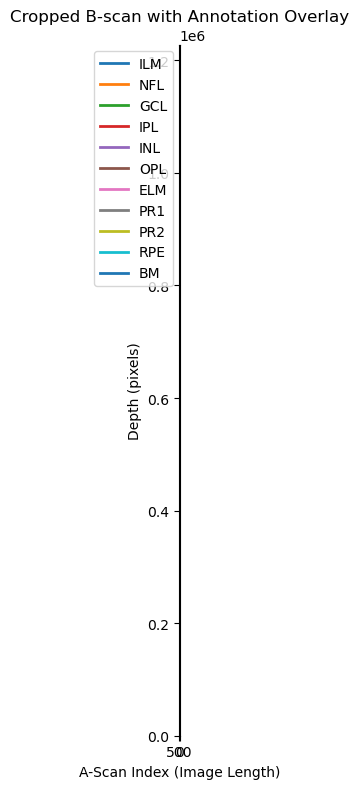

In [33]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the cropped image
img_path = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/final_cropped_bscan_1015.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Annotation parameters
layers = ['ILM', 'NFL', 'GCL', 'IPL', 'INL', 'OPL', 'ELM', 'PR1', 'PR2', 'RPE', 'BM']
bscan_idx = 14  # 15th annotation (0-indexed)
row_idx = 1 + (bscan_idx * 34)  # Each B-scan block is 34 rows

# Get layer rows for this B-scan
start_row = row_idx + 2
layer_rows = [start_row + i * 3 for i in range(len(layers))]

# Plot image
plt.figure(figsize=(12, 8))
plt.imshow(img, cmap='gray')
x = np.arange(10, 769)  # A-scan indices

# Overlay each layer
for i, (layer, row_idx_layer) in enumerate(zip(layers, layer_rows)):
    layer_data = data.iloc[row_idx_layer - 1, 9:768].values  # columns 10 to 768 (0-based)
    y = pd.to_numeric(layer_data, errors='coerce')
    plt.plot(x, y, label=layer, linewidth=2)

plt.title('Cropped B-scan with Annotation Overlay')
plt.xlabel('A-Scan Index (Image Length)')
plt.ylabel('Depth (pixels)')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Annotation range: 532987.00 to 1119175.00
Image height: 444
Scale factor: 0.000757


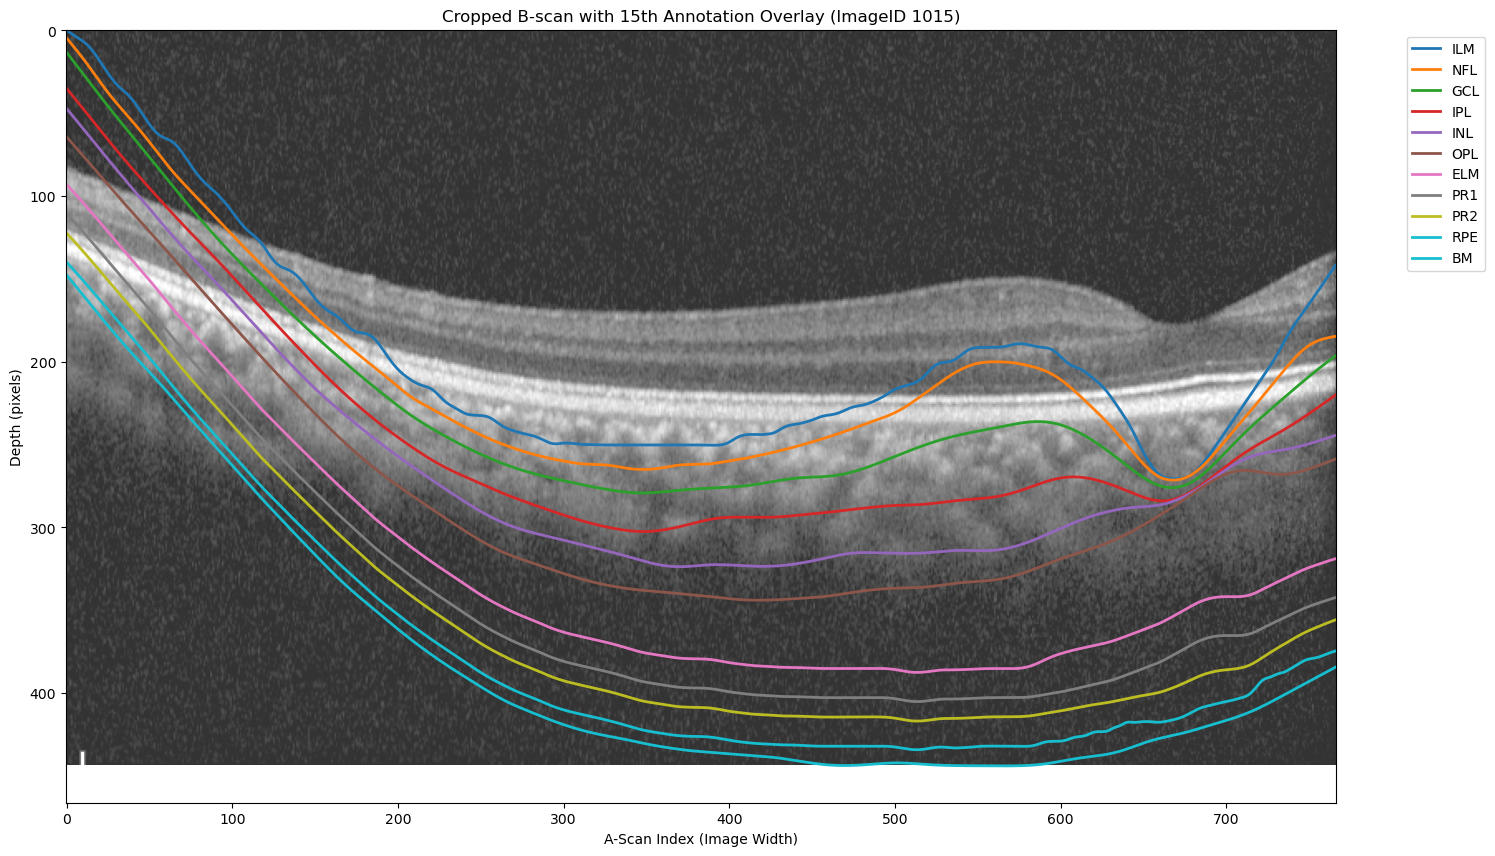

Image shape: (444, 767)
Annotation data length: 767
Valid annotation points: 767
NaN values in annotation: 0


In [41]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the cropped image
img_path = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/final_cropped_bscan_1015.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Annotation parameters for the 15th B-scan (0-indexed)
layers = ['ILM', 'NFL', 'GCL', 'IPL', 'INL', 'OPL', 'ELM', 'PR1', 'PR2', 'RPE', 'BM']
bscan_idx = 15  # 15th annotation (0-indexed)
row_idx = 1 + (bscan_idx * 34)  # Each B-scan block is 34 rows

# Get layer rows for this B-scan
start_row = row_idx + 2
layer_rows = [start_row + i * 3 for i in range(len(layers))]

# Plot image with annotation overlay
plt.figure(figsize=(15, 10))
plt.imshow(img, cmap='gray', alpha=0.8)

# Color map for different layers
colors = plt.cm.tab10(np.linspace(0, 1, len(layers)))

# First, collect all annotation values to determine scaling
all_y_values = []
for i, (layer, row_idx_layer) in enumerate(zip(layers, layer_rows)):
    # Start from column 0 instead of column 9
    layer_data = data.iloc[row_idx_layer - 1, 0:768].values  # columns 0 to 768 (0-based)
    y = pd.to_numeric(layer_data, errors='coerce')
    # Only include valid (non-NaN) values
    valid_y = y[~np.isnan(y)]
    all_y_values.extend(valid_y)

# Calculate scaling factor
min_annotation = np.min(all_y_values)
max_annotation = np.max(all_y_values)
scale_factor = img.shape[0] / (max_annotation - min_annotation)

print(f"Annotation range: {min_annotation:.2f} to {max_annotation:.2f}")
print(f"Image height: {img.shape[0]}")
print(f"Scale factor: {scale_factor:.6f}")

# Overlay each layer with scaled coordinates
for i, (layer, row_idx_layer) in enumerate(zip(layers, layer_rows)):
    # Start from column 0 instead of column 9
    layer_data = data.iloc[row_idx_layer - 1, 0:767].values  # columns 0 to 768 (0-based)
    y = pd.to_numeric(layer_data, errors='coerce')
    
    # Scale the y coordinates to match image dimensions
    y_scaled = (y - min_annotation) * scale_factor
    
    # Create x-axis that matches the annotation data length
    x = np.arange(len(y_scaled))
    
    # Handle NaN values - only plot valid points
    valid_mask = ~np.isnan(y_scaled)
    x_valid = x[valid_mask]
    y_valid = y_scaled[valid_mask]
    
    # Plot the layer boundary
    plt.plot(x_valid, y_valid, label=layer, linewidth=2, color=colors[i])

plt.title('Cropped B-scan with 15th Annotation Overlay (ImageID 1015)')
plt.xlabel('A-Scan Index (Image Width)')
plt.ylabel('Depth (pixels)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the y-axis inversion to fix upside-down orientation
# plt.gca().invert_yaxis()  # Commented out to fix orientation
plt.tight_layout()
plt.show()

print(f"Image shape: {img.shape}")
print(f"Annotation data length: {len(y)}")
print(f"Valid annotation points: {np.sum(valid_mask)}")
print(f"NaN values in annotation: {np.sum(np.isnan(y))}")

In [ ]:
import numpy as np
import pandas as pd
import h5py

def extract_all_layer_maps(data, layers, bscan_start_rows, layer_rows_offset=2, layer_row_step=3, num_x=768):
    """
    Extracts all B-scan layer annotations and saves them to an .h5 file.
    
    Args:
        data: DataFrame containing the OCT data.
        layers: List of layer names.
        bscan_start_rows: List of starting row indices for each B-scan (1-based).
        layer_rows_offset: Offset from bscan start to first layer row.
        layer_row_step: Step between layer rows.
        num_x: Number of x-axis positions (columns per layer).
    """
    num_layers = len(layers)
    num_bscans = len(bscan_start_rows)
    layer_maps = np.zeros((num_bscans, num_x, num_layers))
    
    for b_idx, bscan_row in enumerate(bscan_start_rows):
        layer_rows = [bscan_row + layer_rows_offset + i * layer_row_step for i in range(num_layers)]
        for l_idx, row_idx in enumerate(layer_rows):
            layer_data = data.iloc[row_idx - 1, :num_x].values  # 0-based index
            layer_data = pd.to_numeric(layer_data, errors='coerce')
            layer_maps[b_idx, :, l_idx] = layer_data
    
    # Save to .h5 file
    with h5py.File('layer_maps.h5', 'w') as f:
        f.create_dataset('layer_maps', data=layer_maps, maxshape=(None, 768, 11))
    return layer_maps



In [ ]:

def extract_all_layer_maps(data, layers, bscan_start_rows, layer_rows_offset=2, layer_row_step=3, num_x=768):
    """
    Extracts all B-scan layer annotations, normalizes them, and saves to an .h5 file.

    Args:
        data: DataFrame containing the OCT data.
        layers: List of layer names.
        bscan_start_rows: List of starting row indices for each B-scan (1-based).
        layer_rows_offset: Offset from bscan start to first layer row.
        layer_row_step: Step between layer rows.
        num_x: Number of x-axis positions (columns per layer).
    Returns:
        layer_maps: 3D numpy array of shape (num_bscans, num_x, num_layers) containing the normalized layer data.
    """
    num_layers = len(layers)
    num_bscans = len(bscan_start_rows)
    layer_maps = np.zeros((num_bscans, num_x, num_layers))

    for b_idx, bscan_row in enumerate(bscan_start_rows):
        layer_rows = [bscan_row + layer_rows_offset + i * layer_row_step for i in range(num_layers)]
        for l_idx, row_idx in enumerate(layer_rows):
            layer_data = data.iloc[row_idx - 1, :num_x].values  # 0-based index
            layer_data = pd.to_numeric(layer_data, errors='coerce')
            # Normalize: min-max normalization per layer per B-scan
            min_val = np.nanmin(layer_data)
            max_val = np.nanmax(layer_data)
            if max_val > min_val:
                layer_data = (layer_data - min_val) / (max_val - min_val)
            layer_maps[b_idx, :, l_idx] = layer_data
    # Save to .h5 file
    with h5py.File('layer_maps.h5', 'w') as f:
        f.create_dataset('layer_maps', data=layer_maps, maxshape=(None, 768, 11))
    return layer_maps

In [ ]:
#Function to append new layer maps to an existing .h5 file
def append_layer_maps_h5(new_layer_maps, h5_path='layer_maps.h5'):
    """
    Appends new B-scan layer maps to an existing layer_maps.h5 file.

    Args:
        new_layer_maps: numpy array of shape (num_new_bscans, 768, 11)
        h5_path: path to the .h5 file
    """
    import h5py
    with h5py.File(h5_path, 'a') as f:
        dset = f['layer_maps']
        old_shape = dset.shape[0]
        new_shape = old_shape + new_layer_maps.shape[0]
        dset.resize((new_shape, 768, 11))
        dset[old_shape:new_shape, :, :] = new_layer_maps